In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from SPHERE.preprocess import *
from SPHERE.SPHERE import *
from SPHERE.utils import *
import numpy as np
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
random_seed = 2022
fix_seed(random_seed)

## Spatial ATAC-RNA-seq

In [ ]:
adata = sc.read_h5ad('./P22.h5ad')
lsi(adata, use_highly_variable=False, n_components=201)
adata.obsm['feat'] = adata.obsm['X_lsi'].copy()

In [6]:
adata = construct_neighbor_graph(adata, loc_neighbors=6, gene_neighbors=14, com_neighbors=5)

In [7]:
model = SPHERE(adata, device=device, learning_rate=0.0008, epochs=1000,lambda_fea_recon=0.6,lambda_spa_recon=0.5,
               lambda_recon=1,lambda_con=0.9)

/home/yuzhuohan/workspace/ATAC/our/code_rep/SPHERE/preprocess.py:136: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [8]:
output = model.train()
adata.obsm['latent'] = output['latent']
adata.obsm['latent'] = pca(adata, use_reps='latent', n_comps=20)
sc.pp.neighbors(adata, use_rep='latent', n_neighbors=30)

100%|██████████| 1000/1000 [01:10<00:00, 14.24it/s]


Model training finished!



/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
res = search_res(adata, 16, use_rep='latent', method='leiden', start=0.1, end=1.2, increment=0.01)
sc.tl.leiden(adata, random_state=0, resolution=res)
label_ref = refine_label(adata, 6, key='leiden')
adata.obs['leiden'] = label_ref 

Searching resolution...
resolution=1.1899999999999995, cluster number=18
resolution=1.1799999999999995, cluster number=18
resolution=1.1699999999999995, cluster number=17
resolution=1.1599999999999995, cluster number=17
resolution=1.1499999999999995, cluster number=16


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


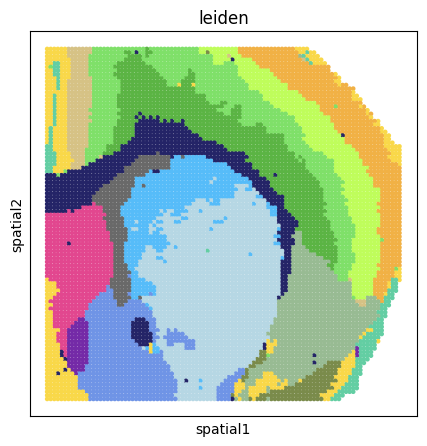

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)
plot_color=["#B6D7E4","#7FE069","#5BB444","#242467","#98BB93","#6F94E6",
        "#F1B145","#56BCF9","#BFFD5B","#F9D849","#E2478F","#696969",
        "#D6C285","#63CEA3", "#7A8B4B", "#742AA7"]
sc.pl.embedding(adata, basis="spatial",
                color="leiden",
                s=45,
                show=True,
                palette=plot_color,legend_loc=None)